In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.tree as tree
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from collections import Counter
import re
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('expedia_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62774 entries, 0 to 62773
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   name                                62774 non-null  object 
 1   current_price                       62774 non-null  float64
 2   reviews_desc                        62774 non-null  int64  
 3   num_reviews                         62774 non-null  float64
 4   breakfast                           62774 non-null  int64  
 5   free_cancellation                   62774 non-null  int64  
 6   grade                               62774 non-null  float64
 7   fully_refundable                    62774 non-null  int64  
 8   reserve_now_pay_later               62774 non-null  int64  
 9   price_after_taxes                   62774 non-null  float64
 10  checkin_date                        62774 non-null  object 
 11  checkout_date                       62774

In [3]:
# Adding features using existing variables

# Handling the hotel name field
# Creating a LabelEncoder object
label_encoder = LabelEncoder()
# Convert names to numeric identifiers
data['hotel_id'] = label_encoder.fit_transform(data['name'])

def convert_to_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

data['checkin_date'] = data['checkin_date'].apply(convert_to_date)
#data['checkin_day'] = data['checkin_date'].dt.day

# Adding a feature for the day of the week based on the check-in date
def get_day_of_week(date_obj):
    # Get the day of the week number (0 - Sunday, 1 - Monday, and so on)
    day_of_week = date_obj.weekday()
    return day_of_week

# Replace the values ​​in the 'bed_type' column with the new classification values
data['checkin_day_week'] = data['checkin_date'].apply(get_day_of_week)

In [4]:
def add_all_services_column(data):
    # Define a condition that checks if all services are offered by the hotel
    conditions = (data['reserve_now_pay_later'] == 1) & \
                 (data['fully_refundable'] == 1) & \
                 (data['free_cancellation'] == 1) & \
                 (data['breakfast'] == 1)
    
    # Add the new column with a result of 1 if all conditions are met, otherwise 0
    data['all_services'] = conditions.astype(int)
    return data

data = add_all_services_column(data)

data.head()
value_counts = data['all_services'].value_counts()
value_counts

all_services
0    59943
1     2831
Name: count, dtype: int64

Correlations with price:
price               1.000000
hotel_id            0.070692
all_services        0.019982
checkin_day_week   -0.051968
Name: price, dtype: float64


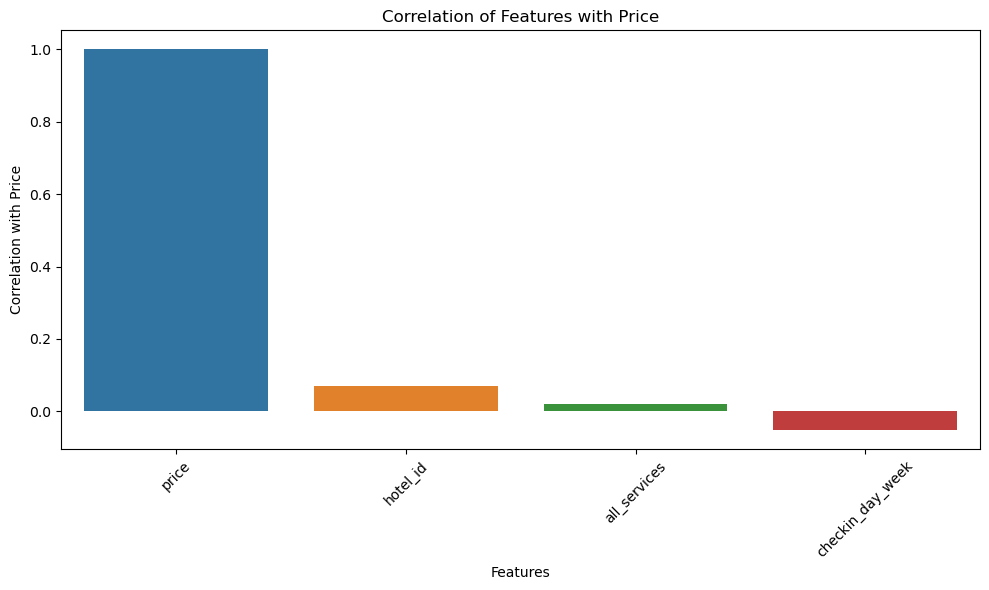

In [5]:
price_correlations = data[['price','all_services', 'checkin_day_week', 'hotel_id']].corr()['price'].sort_values(ascending=False)

print("Correlations with price:")
print(price_correlations)

plt.figure(figsize=(10, 6))
sns.barplot(x=price_correlations.index, y=price_correlations.values)
plt.title('Correlation of Features with Price')
plt.xlabel('Features')
plt.ylabel('Correlation with Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
data = data.drop(['name', 'checkin_date' ,'checkout_date', 'Snapshot Date','current_price','price_after_taxes'], axis=1)


In [7]:
data.describe()

reviews_desc   num_reviews     breakfast  free_cancellation  \
count  62774.000000  62774.000000  62774.000000       62774.000000   
mean       2.946188   1465.367588      0.130420           0.468283   
std        1.110829   1022.960264      0.336768           0.498997   
min        1.000000      1.000000      0.000000           0.000000   
25%        2.000000   1002.000000      0.000000           0.000000   
50%        3.000000   1060.000000      0.000000           0.000000   
75%        4.000000   1651.000000      0.000000           1.000000   
max        5.000000   5946.000000      1.000000           1.000000   

              grade  fully_refundable  reserve_now_pay_later           TTT  \
count  62774.000000      62774.000000           62774.000000  62774.000000   
mean       8.694572          0.468283               0.348504     15.206630   
std        0.576195          0.498997               0.476500      8.652064   
min        7.070000          0.000000               0.000000      0.000000   
25%        8.280000          0.000000               0.000000      8.000000   
50%        8.880000          0.000000               0.000000     15.000000   
75%        9.090000          1.000000               1.000000     23.000000   
max        9.890000          1.000000               1.000000     30.000000   

                LOS         order         price      hotel_id  \
count  62774.000000  62774.000000  62774.000000  62774.000000   
mean       2.977347     78.119970   3434.343422    208.572865   
std        1.408512     43.797325   2835.527222    125.403943   
min        1.000000      2.000000    128.000000      0.000000   
25%        2.000000     40.000000   1036.000000    107.000000   
50%        3.000000     78.000000   2685.000000    194.000000   
75%        4.000000    117.000000   5504.000000    308.000000   
max        5.000000    155.000000  12460.000000    432.000000   

       checkin_day_week  all_services  
count      62774.000000  62774.000000  
mean           3.059563      0.045098  
std            2.040696      0.207521  
min            0.000000      0.000000  
25%            1.000000      0.000000  
50%            3.000000      0.000000  
75%            5.000000      0.000000  
max            6.000000      1.000000

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# מהמוצג לעיל, ניתן לראות שטווחי הנתונים של משתנה "מס' ביקורות" וכן של משתנה "מרחק מהמרכז" שונים מהיתר ולכן ננרמל אותם
columns_to_normalize = [ 'num_reviews']

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
data_min_max_scaled = data.copy()
data_min_max_scaled[columns_to_normalize] = min_max_scaler.fit_transform(data[columns_to_normalize])

# Standardization
standard_scaler = StandardScaler()
data_standard_scaled = data.copy()
data_standard_scaled[columns_to_normalize] = standard_scaler.fit_transform(data[columns_to_normalize])

# הצגת הנתונים המנורמלים
print("Original Data:")
print(data[columns_to_normalize].head())

print("\nMin-Max Scaled Data:")
print(data_min_max_scaled[columns_to_normalize].head())

print("\nStandard Scaled Data:")
print(data_standard_scaled[columns_to_normalize].head())

Original Data:
   num_reviews
0       1306.0
1       3670.0
2        521.0
3       2625.0
4       3586.0

Min-Max Scaled Data:
   num_reviews
0     0.219512
1     0.617157
2     0.087468
3     0.441379
4     0.603028

Standard Scaled Data:
   num_reviews
0    -0.155792
1     2.155167
2    -0.923179
3     1.133614
4     2.073051


## Conclusion

מאחר שהנתונים של מספר ביקורות/חוות דעת מתפלגים א-סימטרית עם זנב ימני ולא התפלגות נורמלית, נעדיף לעשות שימוש בשיטת נרמול של מינימום-מקסימום ונריץ המדולים ע"ב הדטה הכולל את הנרמול הנל

In [9]:
data_wo_features = data_min_max_scaled.drop(['checkin_day_week','all_services','hotel_id'], axis=1)

# Algorithm -LinearRegression

#### Split the data to training set and test set.

DataFrame: data_min_max_scaled
--------------------------------

Intercept: -7154.379046388149
                                      Coeff
neighborhood_Williamsburg          3106.408
neighborhood_Central New York City 2947.833
neighborhood_Upper West Side       2812.345
neighborhood_Theater District      2790.381
neighborhood_SoHo                  2735.005
neighborhood_Jersey City           2670.030
neighborhood_Chelsea               2600.863
neighborhood_New York              2501.413
neighborhood_Greenwich Village     2500.505
neighborhood_Brooklyn              2458.437
neighborhood_Queens                2413.764
neighborhood_Long Island City      2406.308
neighborhood_Downtown Brooklyn     2130.189
neighborhood_Harlem                2064.778
neighborhood_Jamaica               1938.821
LOS                                1861.402
neighborhood_Flushing              1852.637
neighborhood_Bronx                  451.238
num_reviews                         437.142
grade                    

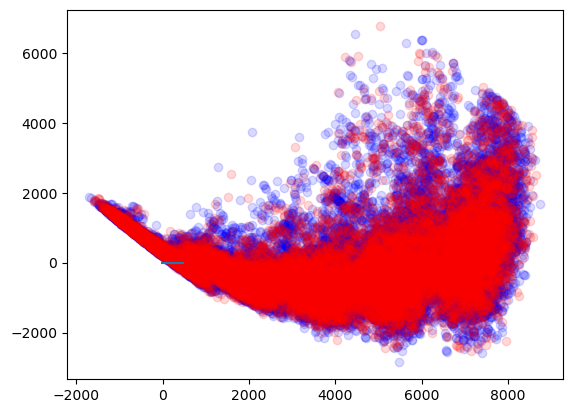

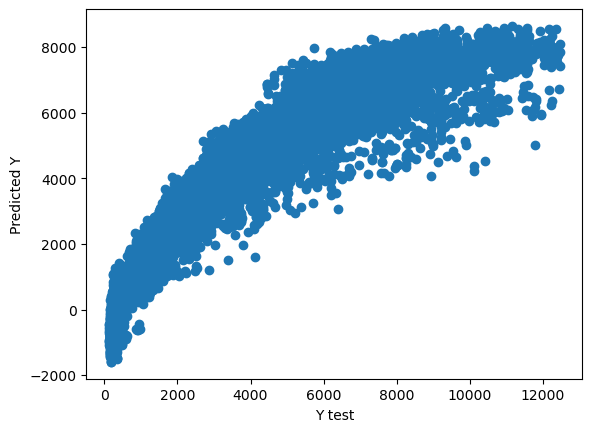

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


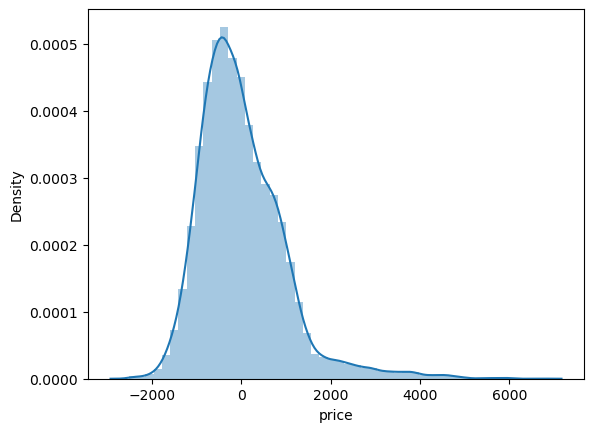

DataFrame: data_wo_features
--------------------------------

Intercept: -6957.177131574113
                                      Coeff
neighborhood_Williamsburg          2833.171
neighborhood_Central New York City 2671.129
neighborhood_Upper West Side       2554.925
neighborhood_Theater District      2539.936
neighborhood_SoHo                  2445.159
neighborhood_Jersey City           2410.343
neighborhood_Greenwich Village     2320.057
neighborhood_Brooklyn              2318.487
neighborhood_Chelsea               2283.323
neighborhood_Queens                2239.837
neighborhood_New York              2227.604
neighborhood_Long Island City      2106.142
neighborhood_Downtown Brooklyn     1930.041
LOS                                1863.186
neighborhood_Harlem                1740.813
neighborhood_Flushing              1334.637
neighborhood_Jamaica               1155.221
neighborhood_Bronx                  938.428
num_reviews                         426.705
reviews_desc                

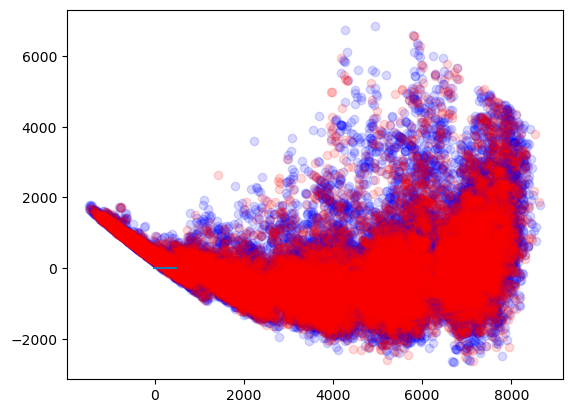

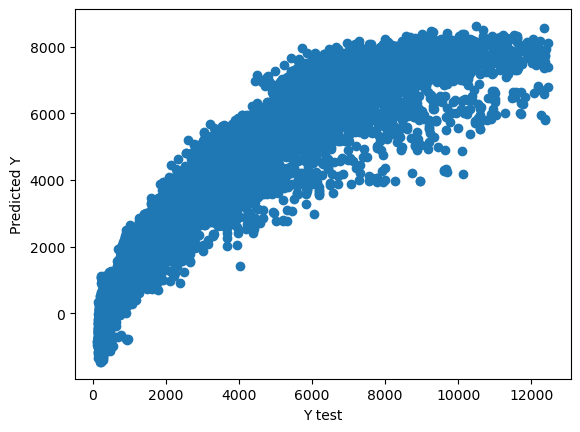

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


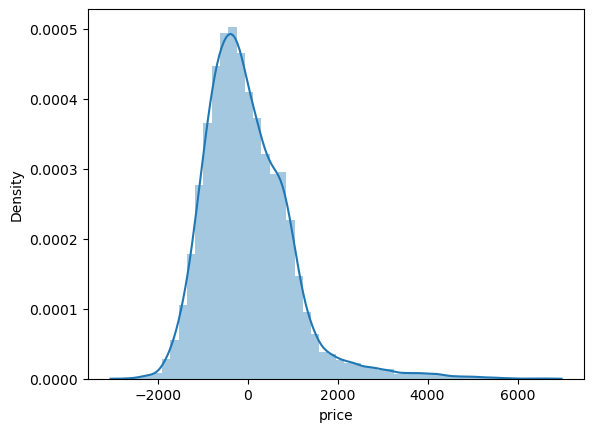

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


data_types = [data_min_max_scaled, data_wo_features]

for df in data_types:
    df_name = next(key for key, value in locals().items() if value is df)
    print(f"DataFrame: {df_name}")
    print("--------------------------------")
    print()
    
    X = df.drop('price', axis=1)
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    print(f'Intercept: {lr.intercept_}')
    
    pd.options.display.float_format = '{:.3f}'.format
    cdf = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coeff'])
    print(cdf.sort_values('Coeff', ascending=False))
    print()

    #### Predict the test se-t
    pred_test = lr.predict(X_test)
    pred_train = lr.predict(X_train)

    #### Print the relevant evaluation metrics
    print('Test MAE: ', "%.4f" % mean_absolute_error(y_test, pred_test))
    print('Test MSE: ', "%.4f" % mean_squared_error(y_test, pred_test))
    print('Test RMSE: ', "%.4f" % np.sqrt(mean_squared_error(y_test, pred_test)))
    print('Test R2: ', "%.4f" % r2_score(y_test, pred_test))
    print()
    print('Train MAE: ', "%.4f" % mean_absolute_error(y_train,pred_train))
    print('Train MSE: ', "%.4f" % mean_squared_error(y_train,pred_train))
    print('Train RMSE: ', "%.4f" % np.sqrt(mean_squared_error(y_train,pred_train)))
    print('Train R2: ', "%.4f" % r2_score(y_train,pred_train))
    print()
    
    #### Print a scatterplot of the real y values of the test set against the predicted y values
    plt.scatter(pred_train, y_train-pred_train, c='b',alpha=0.15)
    plt.scatter(pred_test, y_test-pred_test, c='r',alpha=0.15)
    plt.hlines(y=0,xmin=-50,xmax=500)
    plt.show()

    plt.scatter(y_test, pred_test)
    plt.xlabel('Y test')
    plt.ylabel('Predicted Y')
    plt.show()

    #### Print a histogram the residuals
    sns.distplot(y_test-pred_test)
    plt.show()


## Conclusion
The coefficient values ​​indicate the size and direction of the effect of each variable on the dependent variable (price).

Neighborhoods have a positive (some very strong) effect on price.

Additional features:

Very weak effect


# Algorithm - Decision Tree Regressor

In [11]:
from sklearn import tree
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from IPython.display import Image
import pydotplus

DataFrame: data
--------------------------------

Max_depth: 2



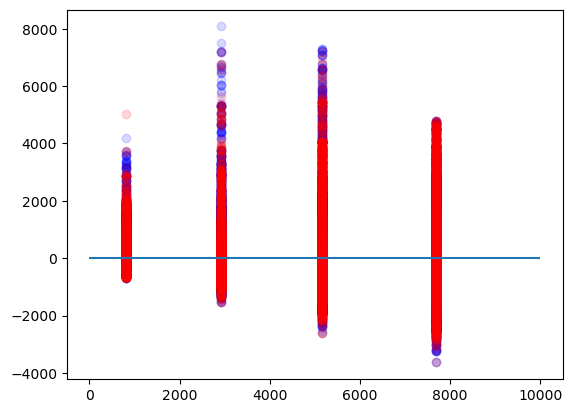

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


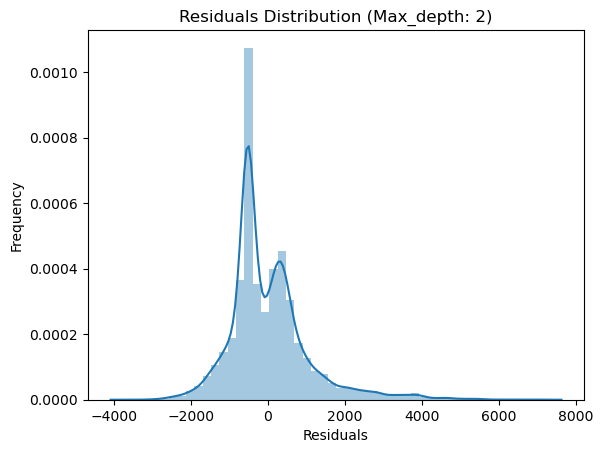

Max_depth: 3



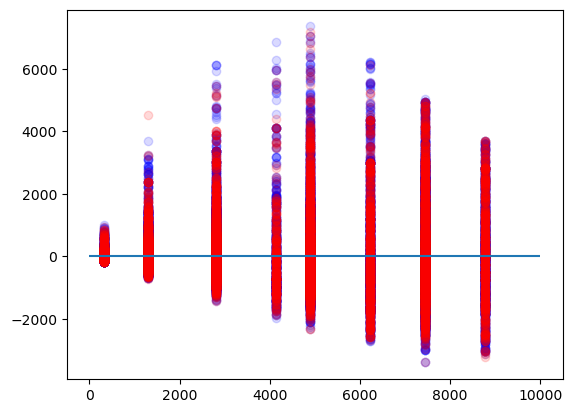

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


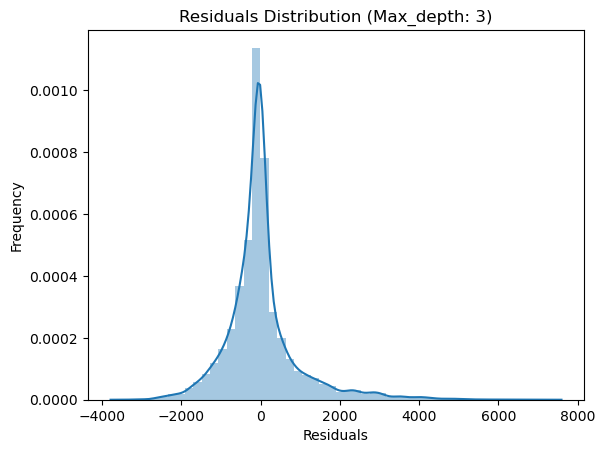

Max_depth: 5



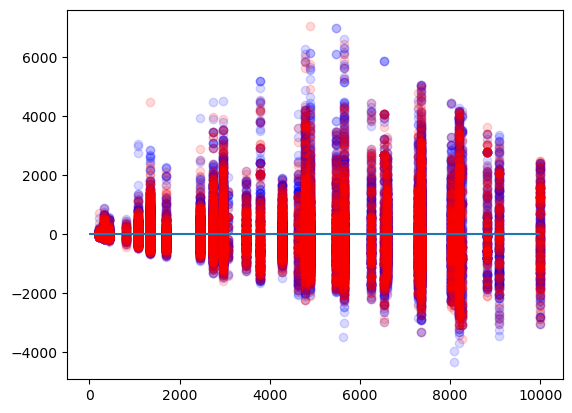

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


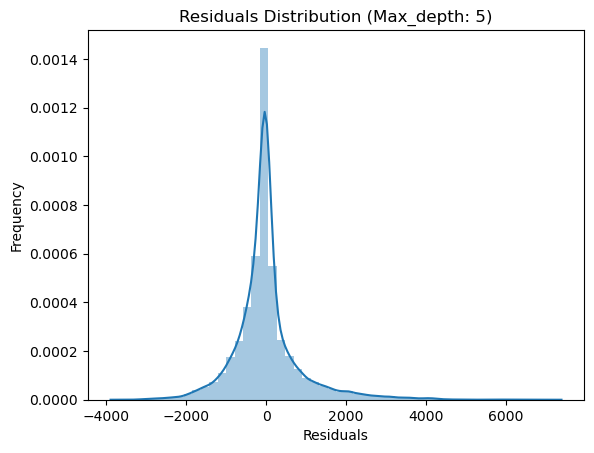

Max_depth: 8



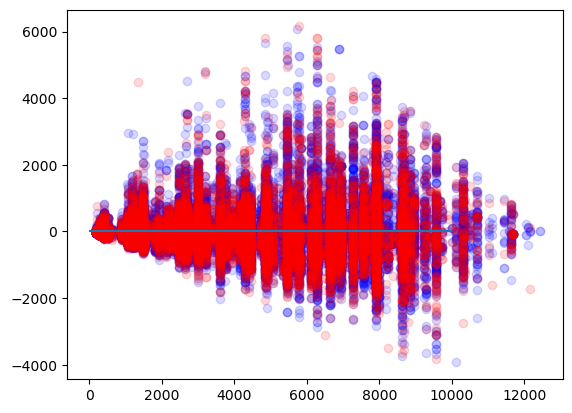

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


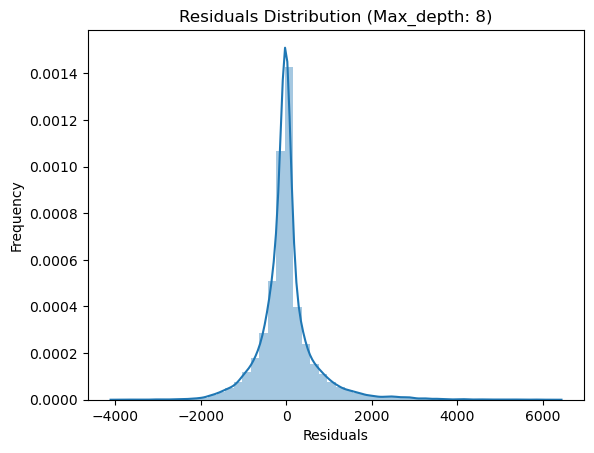

Max_depth: 10



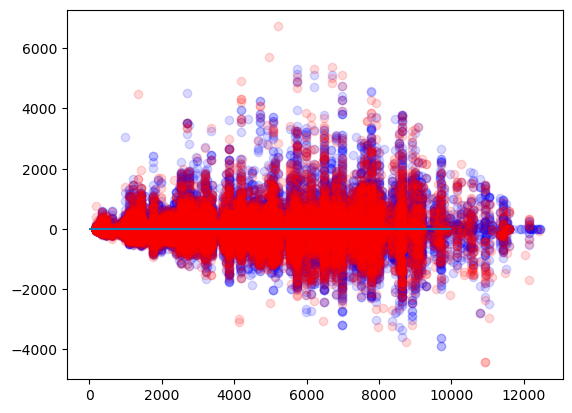

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


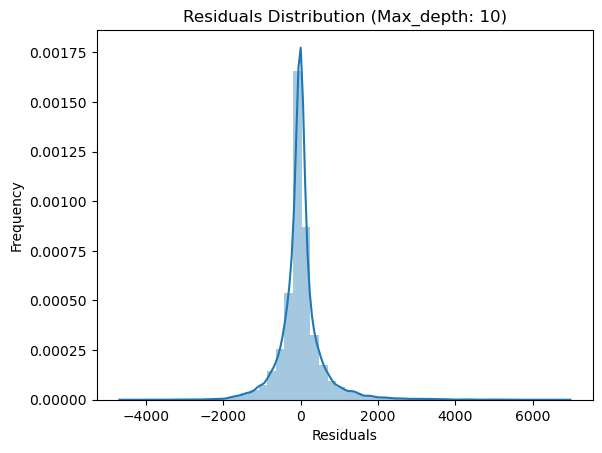

Test Set Results:
   Depth  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      2         1115456.163                 1056.152              758.370   
1      3          878499.291                  937.283              582.465   
2      5          709370.565                  842.241              519.073   
3      8          450021.004                  670.836              400.316   
4     10          339786.996                  582.913              338.109   

    R^2  
0 0.864  
1 0.893  
2 0.914  
3 0.945  
4 0.959  
Train Set Results:
   Depth  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      2         1064945.436                 1031.962              740.425   
1      3          833688.678                  913.066              569.650   
2      5          664591.452                  815.225              505.287   
3      8          399203.982                  631.826              378.563   
4     10          268042.021                

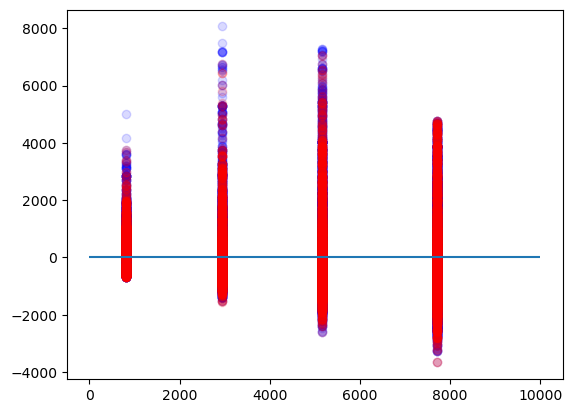

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


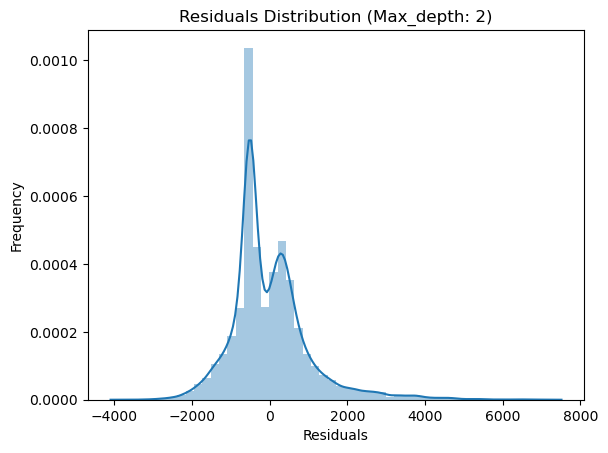

Max_depth: 3



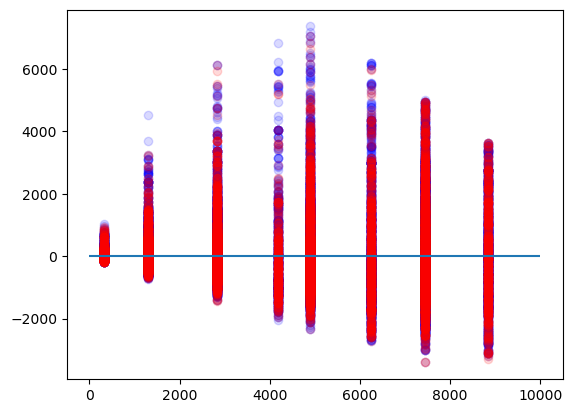

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


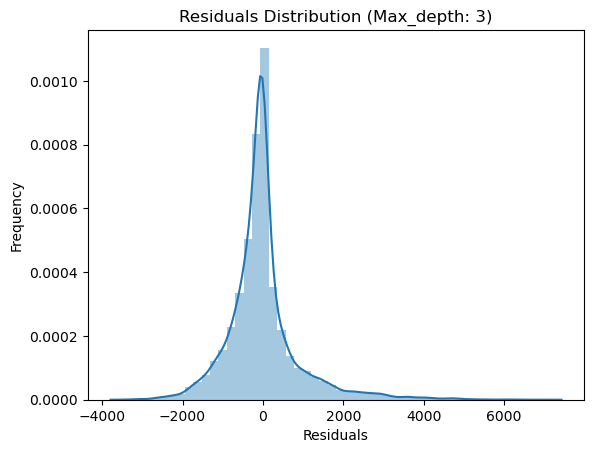

Max_depth: 5



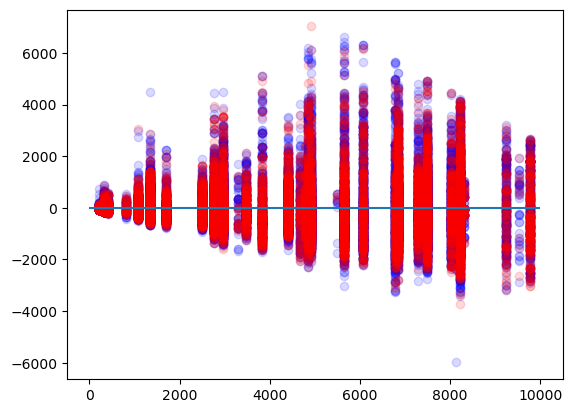

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


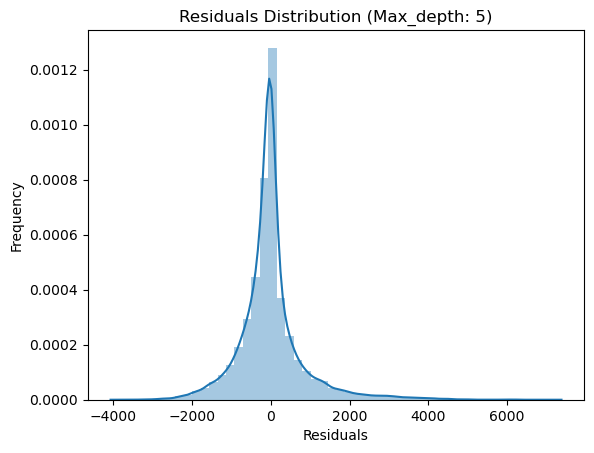

Max_depth: 8



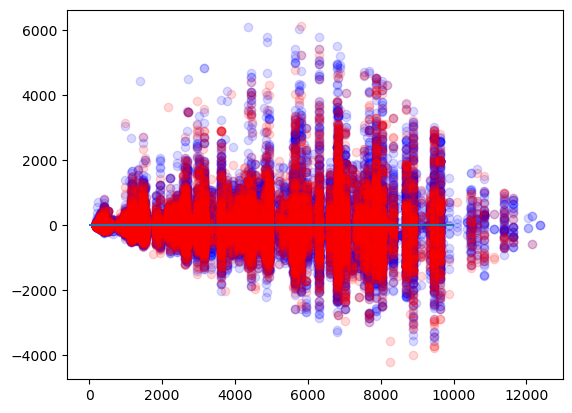

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


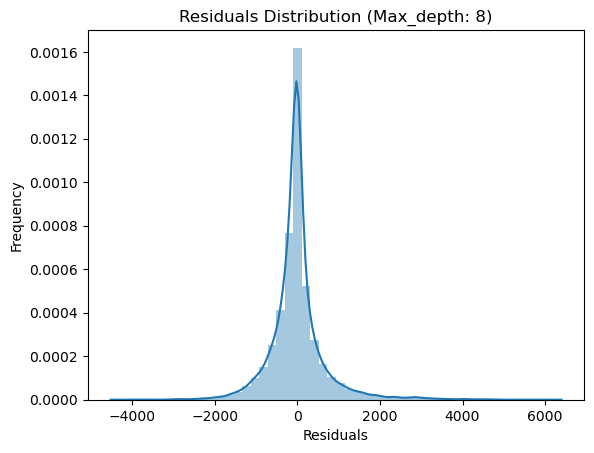

Max_depth: 10



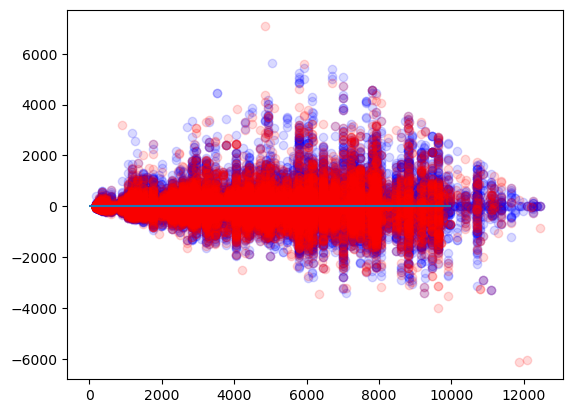

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


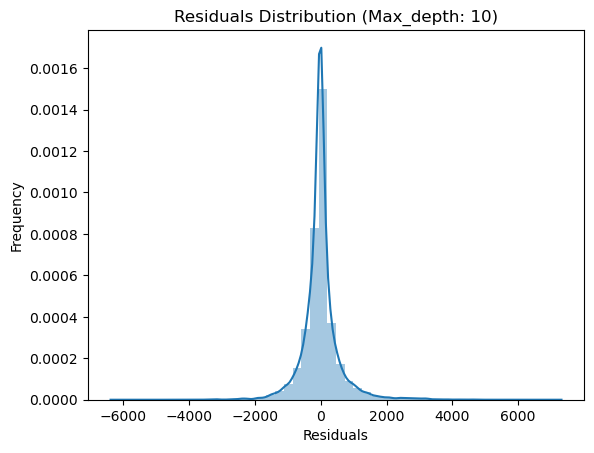

Test Set Results:
   Depth  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      2         1048143.793                 1023.789              742.555   
1      3          839287.255                  916.126              574.064   
2      5          701840.679                  837.759              515.970   
3      8          457927.131                  676.703              404.294   
4     10          338480.363                  581.791              339.257   

    R^2  
0 0.869  
1 0.895  
2 0.912  
3 0.943  
4 0.958  
Train Set Results:
   Depth  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      2         1093617.795                 1045.762              749.906   
1      3          850472.616                  922.211              575.033   
2      5          679386.597                  824.249              507.268   
3      8          417236.146                  645.938              385.555   
4     10          279632.305                

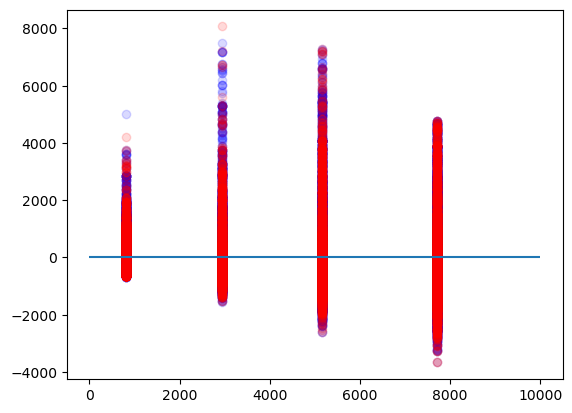

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


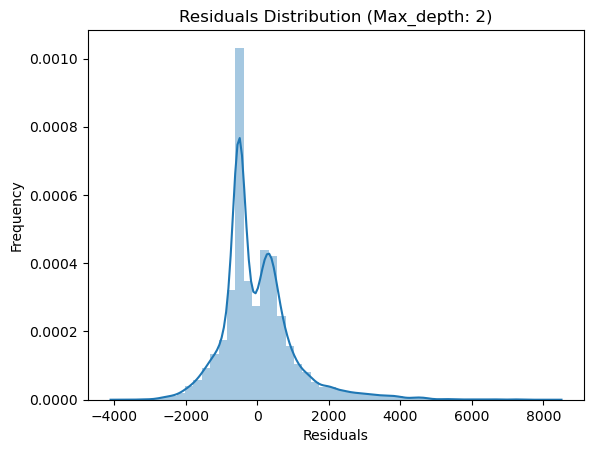

Max_depth: 3



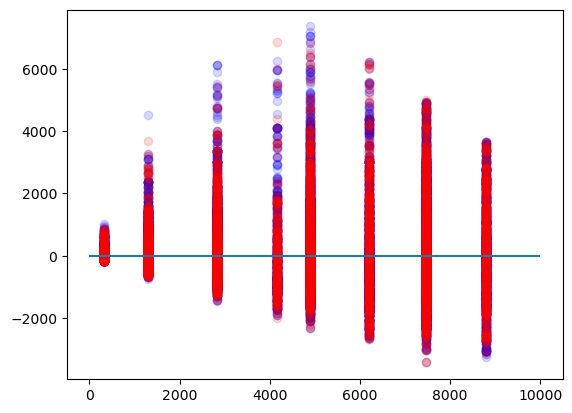

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


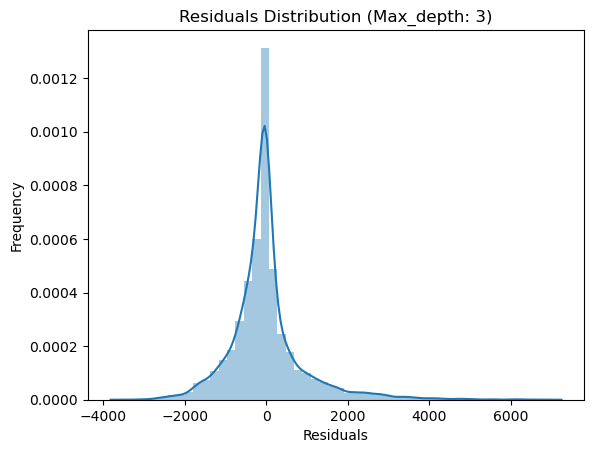

Max_depth: 5



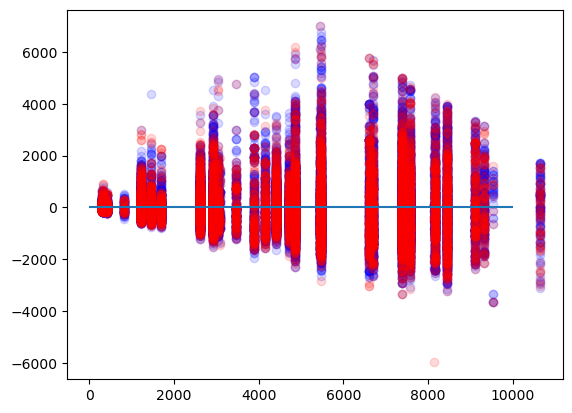

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


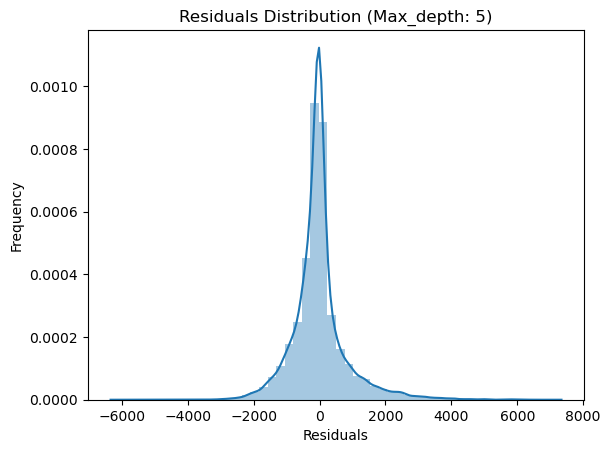

Max_depth: 8



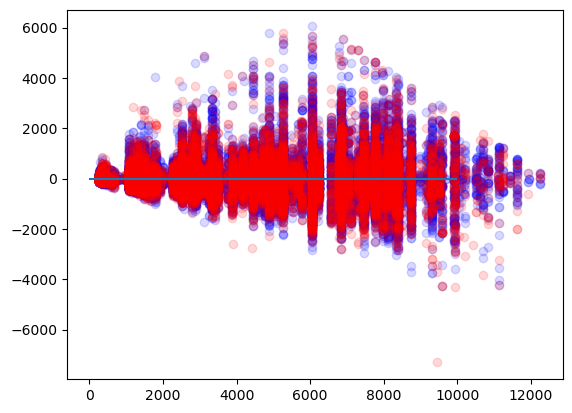

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


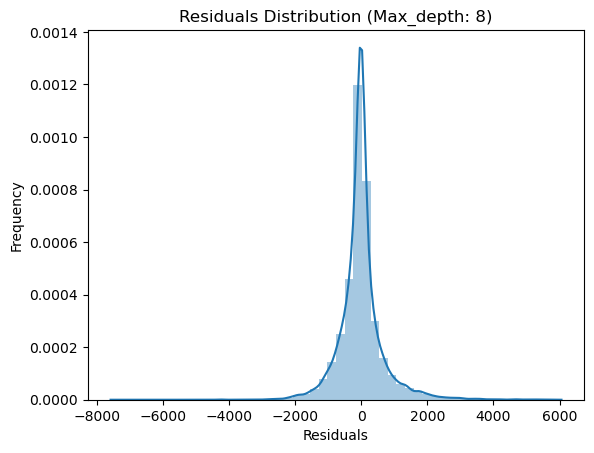

Max_depth: 10



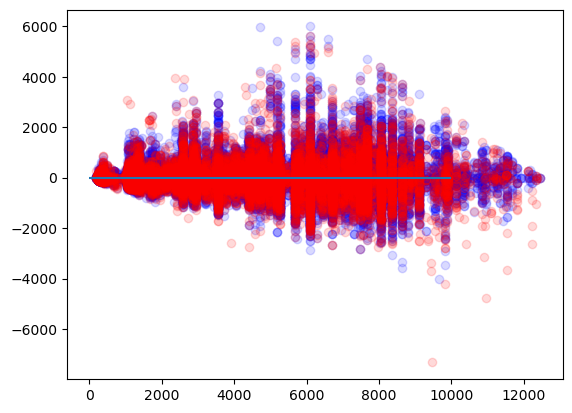

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


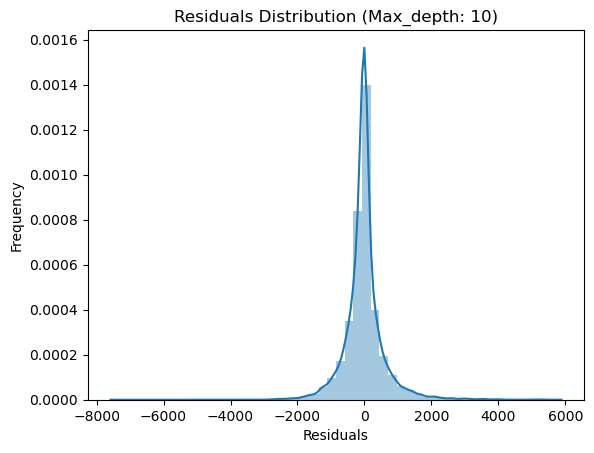

Test Set Results:
   Depth  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      2         1082949.484                 1040.649              750.583   
1      3          845904.455                  919.731              578.143   
2      5          706821.045                  840.726              527.490   
3      8          473866.699                  688.380              421.520   
4     10          365973.111                  604.957              365.245   

    R^2  
0 0.866  
1 0.895  
2 0.913  
3 0.941  
4 0.955  
Train Set Results:
   Depth  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      2         1078671.025                 1038.591              745.671   
1      3          847491.670                  920.593              573.110   
2      5          693850.322                  832.977              519.024   
3      8          427246.818                  653.641              402.231   
4     10          305955.794                

In [12]:
data_types = [data,data_min_max_scaled, data_wo_features]
depth_values = [2, 3, 5, 8, 10]

for df in data_types:
    df_name = next(key for key, value in locals().items() if value is df)
    print(f"DataFrame: {df_name}")
    print("--------------------------------")
    print()
    
    X = df.drop('price', axis=1)
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    results = {}
    for depth in depth_values:
        print(f"Max_depth: {depth}")
        print()
        DesTree = tree.DecisionTreeRegressor(max_depth=depth)
        DesTree.fit(X_train, y_train)

        #### Predict the test set
        pred_test = DesTree.predict(X_test)
        mse_test = mean_squared_error(y_test, pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
        mae_test = mean_absolute_error(y_test, pred_test)
        r2_test = r2_score(y_test, pred_test)

        #### Predict the train set
        pred_train = DesTree.predict(X_train)
        mse_train = mean_squared_error(y_train,pred_train)
        rmse_train = np.sqrt(mean_squared_error(y_train,pred_train))
        mae_train = mean_absolute_error(y_train,pred_train)
        r2_train = r2_score(y_train,pred_train)
        
        #### Print a scatterplot of the real y values of the test set against the predicted y values
        plt.scatter(pred_train, y_train-pred_train, c='b',alpha=0.15)
        plt.scatter(pred_test, y_test-pred_test, c='r',alpha=0.15)
        plt.hlines(y=0,xmin=0,xmax=10000)
        plt.show()

        #### Print a histogram the residuals
        sns.distplot(y_test-pred_test)
        plt.title(f"Residuals Distribution (Max_depth: {depth})")
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()

        results[depth] = {
            'test': {'mse': mse_test, 'rmse': rmse_test, 'mae': mae_test, 'r2': r2_test, 'y_pred': pred_test},
            'train': {'mse': mse_train, 'rmse': rmse_train, 'mae': mae_train, 'r2': r2_train, 'y_pred': pred_train}
        }
        

    results_df_test = pd.DataFrame([(depth, res['test']['mse'], res['test']['rmse'], res['test']['mae'], res['test']['r2']) for depth, res in results.items()],
                              columns=['Depth', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])
    
    results_df_train = pd.DataFrame([(depth, res['train']['mse'], res['train']['rmse'], res['train']['mae'], res['train']['r2']) for depth, res in results.items()],
                              columns=['Depth', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])
    
    print("Test Set Results:")
    print(results_df_test)
    
    print("Train Set Results:")
    print(results_df_train)
    print()



## Conclusion
The greater the depth of the tree, the better the results and the better the model. However, it is possible that this is an overfitting, so we will examine additional depths and try to limit the depth of the tree.

When the tree depth was 2, the results were less good than those of the linear regression.Starting from a depth of 3 faults, better results compared to linear regression

We ran it several times, we will also try to perform a different distribution and increase the test at the expense of the train and examine the effectעה

## Split the data to training set and test set

DataFrame: data
--------------------------------

Test_size: 0.2



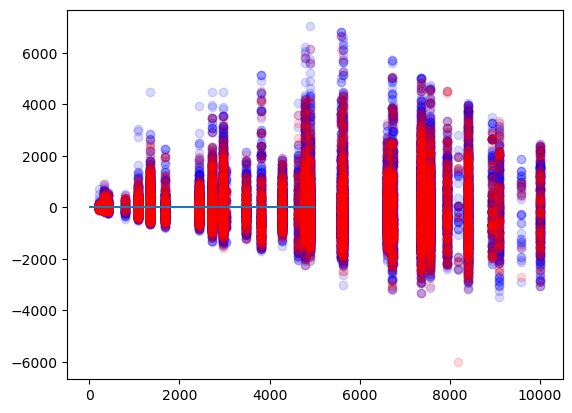

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


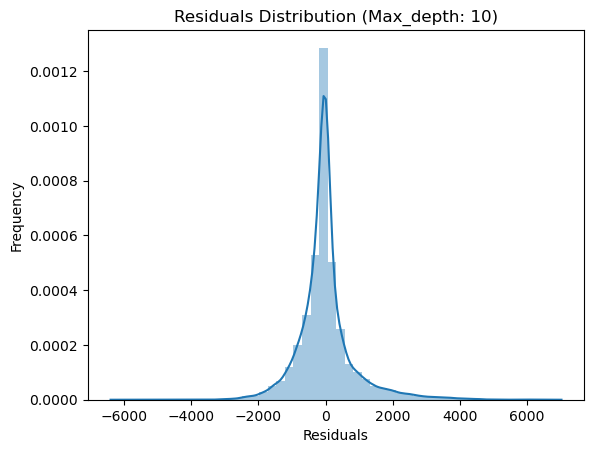

Test_size: 0.4



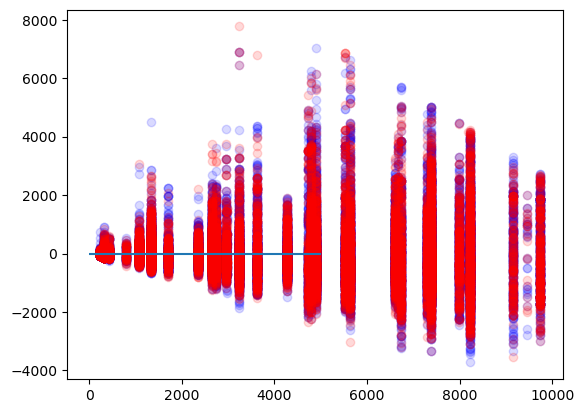

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


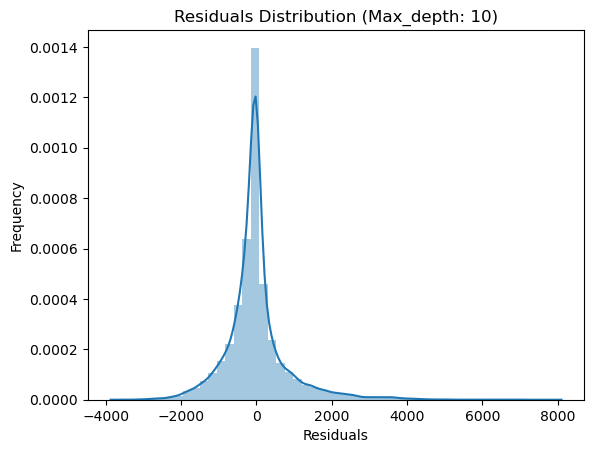

Test_size: 0.5



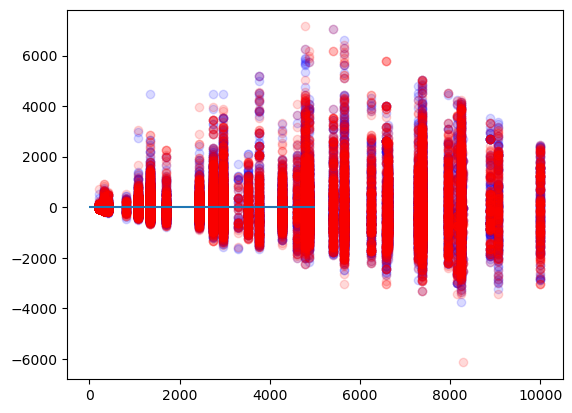

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


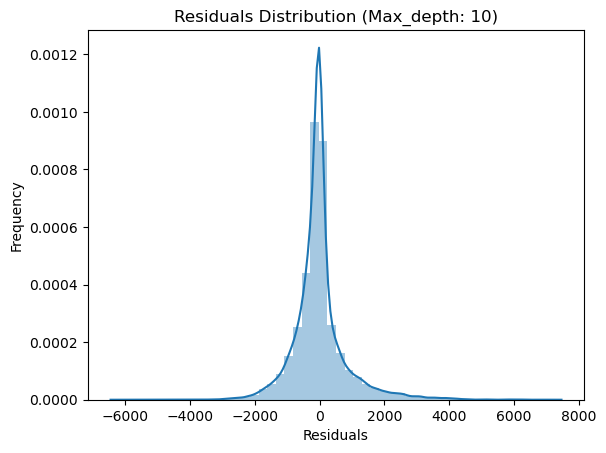

Test Set Results:
   Size  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0 0.200          700934.741                  837.218              517.869   
1 0.400          713930.513                  844.944              516.240   
2 0.500          685499.286                  827.949              512.140   

    R^2  
0 0.913  
1 0.911  
2 0.915  
Train Set Results:
   Size  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0 0.200          680631.042                  825.004              508.942   
1 0.400          684655.119                  827.439              510.420   
2 0.500          667583.519                  817.058              507.758   

    R^2  
0 0.915  
1 0.915  
2 0.917  

DataFrame: data_min_max_scaled
--------------------------------

Test_size: 0.2



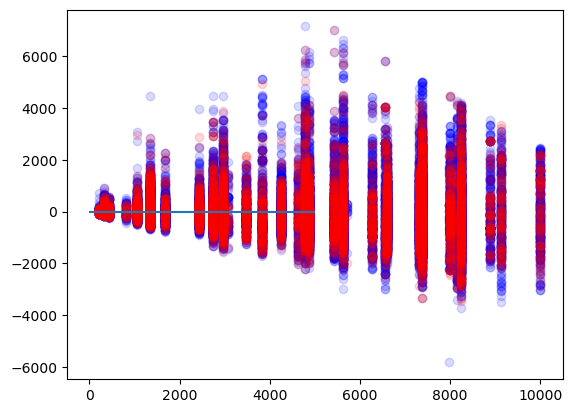

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


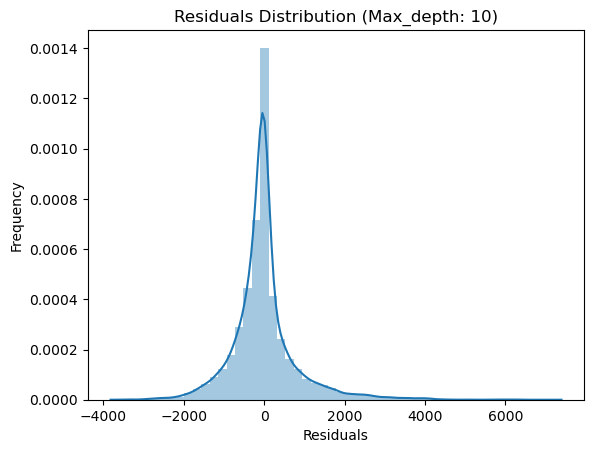

Test_size: 0.4



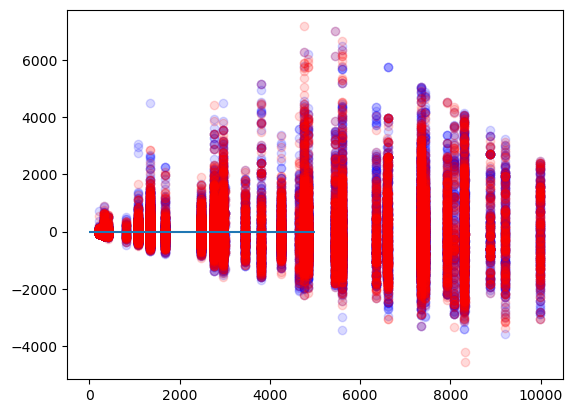

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


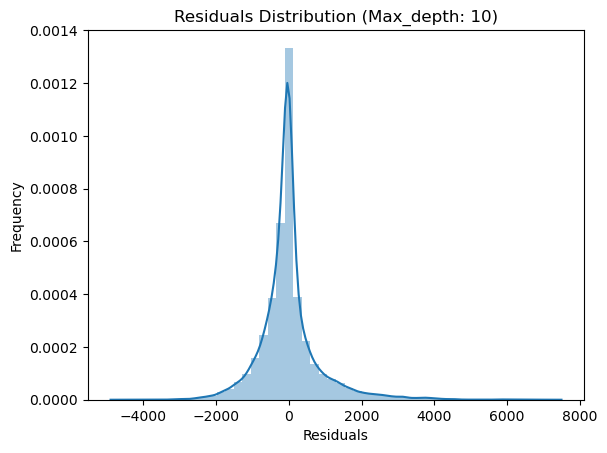

Test_size: 0.5



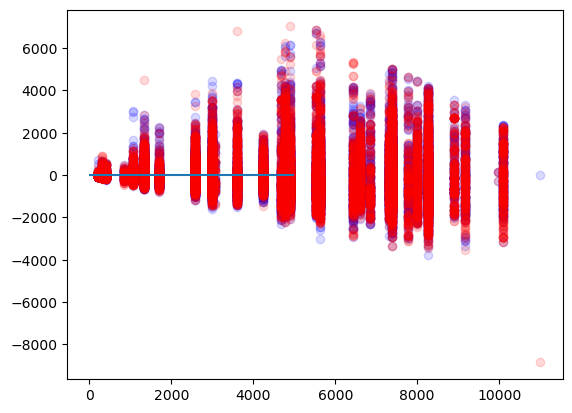

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


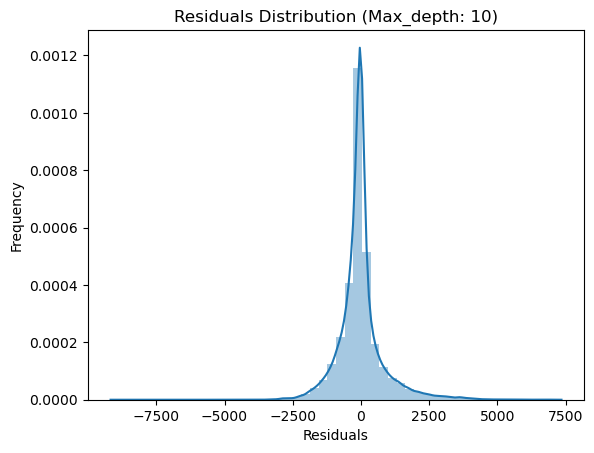

Test Set Results:
   Size  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0 0.200          665249.150                  815.628              507.009   
1 0.400          698485.725                  835.755              514.474   
2 0.500          706970.159                  840.815              516.218   

    R^2  
0 0.916  
1 0.913  
2 0.912  
Train Set Results:
   Size  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0 0.200          679162.984                  824.113              510.203   
1 0.400          664017.939                  814.873              506.083   
2 0.500          688237.515                  829.601              513.013   

    R^2  
0 0.916  
1 0.918  
2 0.915  

DataFrame: data_wo_features
--------------------------------

Test_size: 0.2



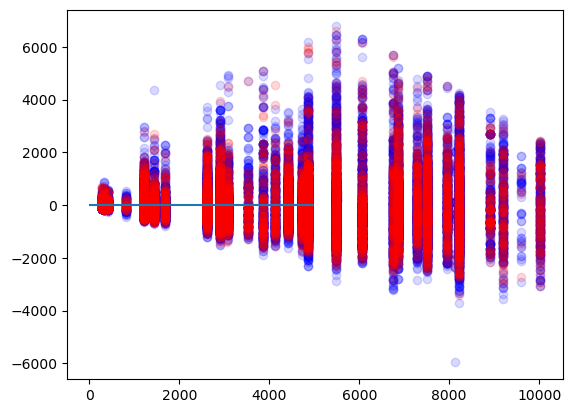

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


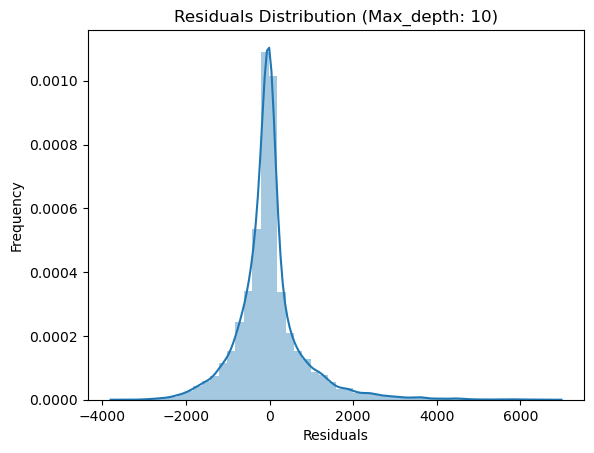

Test_size: 0.4



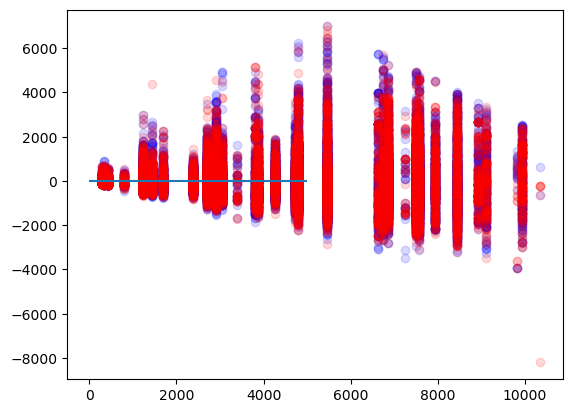

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


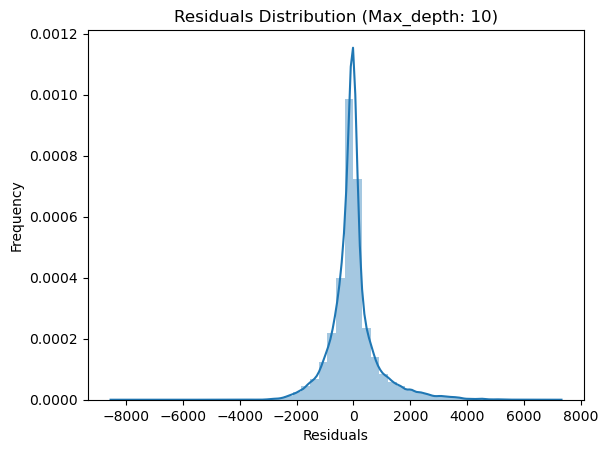

Test_size: 0.5



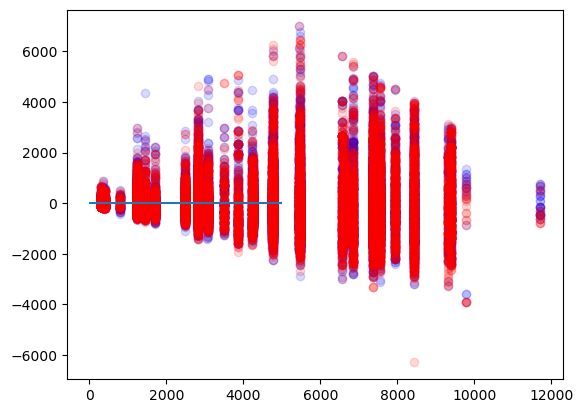

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


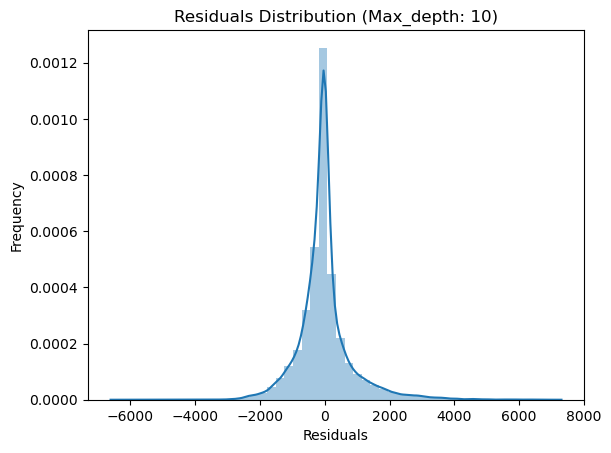

Test Set Results:
   Size  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0 0.200          689031.635                  830.079              515.092   
1 0.400          704444.920                  839.312              521.141   
2 0.500          710344.673                  842.819              525.518   

    R^2  
0 0.914  
1 0.913  
2 0.912  
Train Set Results:
   Size  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0 0.200          697051.034                  834.896              519.007   
1 0.400          691828.586                  831.762              517.160   
2 0.500          683631.442                  826.820              520.359   

    R^2  
0 0.913  
1 0.914  
2 0.915  



In [13]:
data_types = [data, data_min_max_scaled, data_wo_features]
test_size_values = [0.2, 0.4, 0.5]

for df in data_types:
    df_name = next(key for key, value in locals().items() if value is df)
    print(f"DataFrame: {df_name}")
    print("--------------------------------")
    print()
    
    X = df.drop('price', axis=1)
    y = df['price']
    results = {}
    
    for size in test_size_values:
        print(f"Test_size: {size}")
        print()
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
        DesTree = tree.DecisionTreeRegressor(max_depth=5)
        DesTree.fit(X_train, y_train)
        
        #### Predict the test set
        pred_test = DesTree.predict(X_test)
        mse_test = mean_squared_error(y_test, pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
        mae_test = mean_absolute_error(y_test, pred_test)
        r2_test = r2_score(y_test, pred_test)

        #### Predict the train set
        pred_train = DesTree.predict(X_train)
        mse_train = mean_squared_error(y_train,pred_train)
        rmse_train = np.sqrt(mean_squared_error(y_train,pred_train))
        mae_train = mean_absolute_error(y_train,pred_train)
        r2_train = r2_score(y_train,pred_train)
        
        #### Print a scatterplot of the real y values of the test set against the predicted y values
        plt.scatter(pred_train, y_train-pred_train, c='b',alpha=0.15)
        plt.scatter(pred_test, y_test-pred_test, c='r',alpha=0.15)
        plt.hlines(y=0,xmin=0,xmax=5000)
        plt.show()

        #### Print a histogram the residuals
        sns.distplot(y_test-pred_test)
        plt.title(f"Residuals Distribution (Max_depth: {depth})")
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()

        results[size] = {
            'test': {'mse': mse_test, 'rmse': rmse_test, 'mae': mae_test, 'r2': r2_test, 'y_pred': pred_test},
            'train': {'mse': mse_train, 'rmse': rmse_train, 'mae': mae_train, 'r2': r2_train, 'y_pred': pred_train}
        }
        

    results_df_test = pd.DataFrame([(size, res['test']['mse'], res['test']['rmse'], res['test']['mae'], res['test']['r2']) for size, res in results.items()],
                              columns=['Size', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])
    
    results_df_train = pd.DataFrame([(size, res['train']['mse'], res['train']['rmse'], res['train']['mae'], res['train']['r2']) for size, res in results.items()],
                              columns=['Size', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])
    
    print("Test Set Results:")
    print(results_df_test)
    
    print("Train Set Results:")
    print(results_df_train)
    print()


## Conclusion
Relatively similar results were obtained in the different distributions

Let's try to test RandomForestRegressor

## Use RandomForestRegressor

Test MAE:  488.9629
Test MSE:  625169.6211
Test RMSE:  790.6767
Test R2:  0.9220

Train MAE:  488.5190
Train MSE:  625251.5998
Train RMSE:  790.7285
Train R2:  0.9223


C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


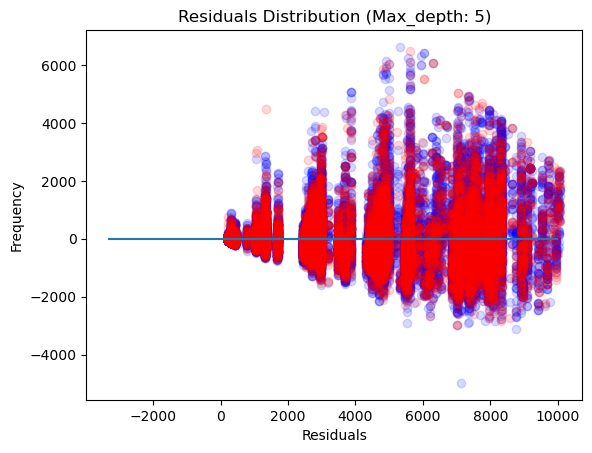

In [14]:
from sklearn.ensemble import RandomForestRegressor

X = data_min_max_scaled.drop('price', axis=1)
y = data_min_max_scaled['price']

#data_wo_features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Random_Forest = RandomForestRegressor(n_estimators=200, max_depth=5)
Random_Forest.fit(X_train, y_train)
pred_train = Random_Forest.predict(X_train)
pred_test = Random_Forest.predict(X_test)

print('Test MAE: ', "%.4f" % mean_absolute_error(y_test, pred_test))
print('Test MSE: ', "%.4f" % mean_squared_error(y_test, pred_test))
print('Test RMSE: ', "%.4f" % np.sqrt(mean_squared_error(y_test, pred_test)))
print('Test R2: ', "%.4f" % r2_score(y_test, pred_test))
print()
print('Train MAE: ', "%.4f" % mean_absolute_error(y_train,pred_train))
print('Train MSE: ', "%.4f" % mean_squared_error(y_train,pred_train))
print('Train RMSE: ', "%.4f" % np.sqrt(mean_squared_error(y_train,pred_train)))
print('Train R2: ', "%.4f" % r2_score(y_train,pred_train))

# Print scatter plot
plt.scatter(pred_train, y_train-pred_train, c='b',alpha=0.15)
plt.scatter(pred_test, y_test-pred_test, c='r',alpha=0.15)
plt.hlines(y=0,xmin=0,xmax=10000)

#### Print a histogram the residuals
sns.distplot(y_test-pred_test)
plt.title(f"Residuals Distribution (Max_depth: {5})")
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Conclusion
The model is better than the previous models

# feature importance

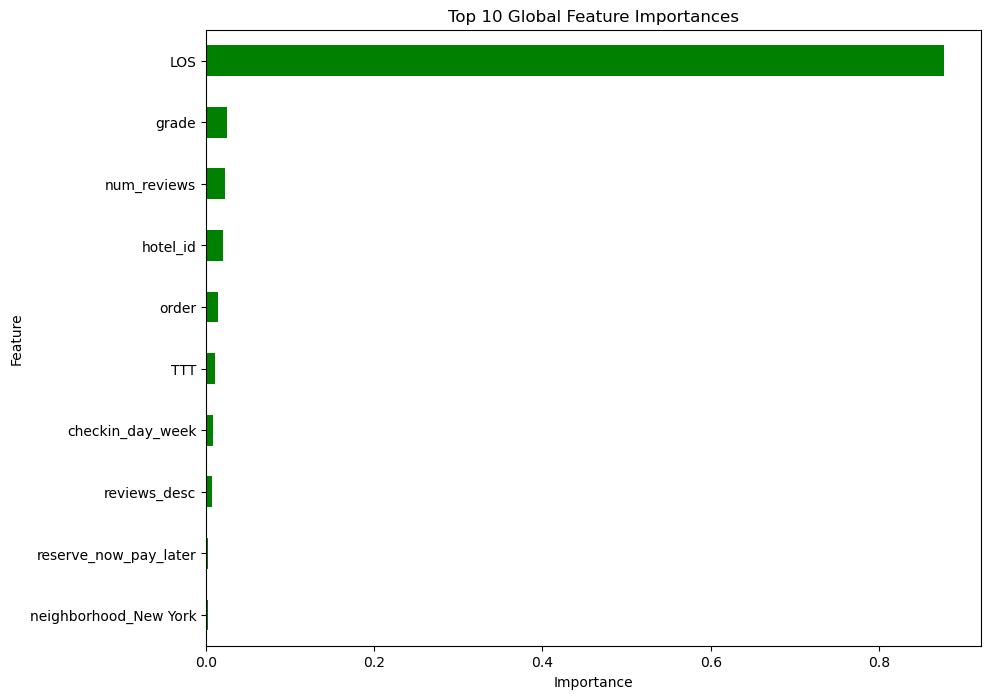

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

Random_Forest = RandomForestRegressor(n_estimators=200)
Random_Forest.fit(X_train, y_train)

#feature_names = [f"feature {i}" for i in range(X.shape[1])]
data = data_min_max_scaled.drop('price', axis=1)
feature_names = data.columns[0:]

# Convert feature importances to a pandas Series
global_importances = pd.Series(Random_Forest.feature_importances_, index=feature_names)

# Sort the importances Series and select the top 10 features
global_importances_sorted = global_importances.nlargest(10)

# Reverse the Series to have the highest importance at the top for plotting
global_importances_sorted = global_importances_sorted.iloc[::-1]

# Plot the sorted top 10 feature importances
plt.figure(figsize=(10, 8))
global_importances_sorted.plot(kind='barh', color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Global Feature Importances")
plt.show()

## Use feature importance - blackbox

                  feature  importance
8                     LOS       1.872
4                   grade       0.069
1             num_reviews       0.039
27               hotel_id       0.037
9                   order       0.034
7                     TTT       0.025
28       checkin_day_week       0.018
0            reviews_desc       0.017
6   reserve_now_pay_later       0.005
21  neighborhood_New York       0.004


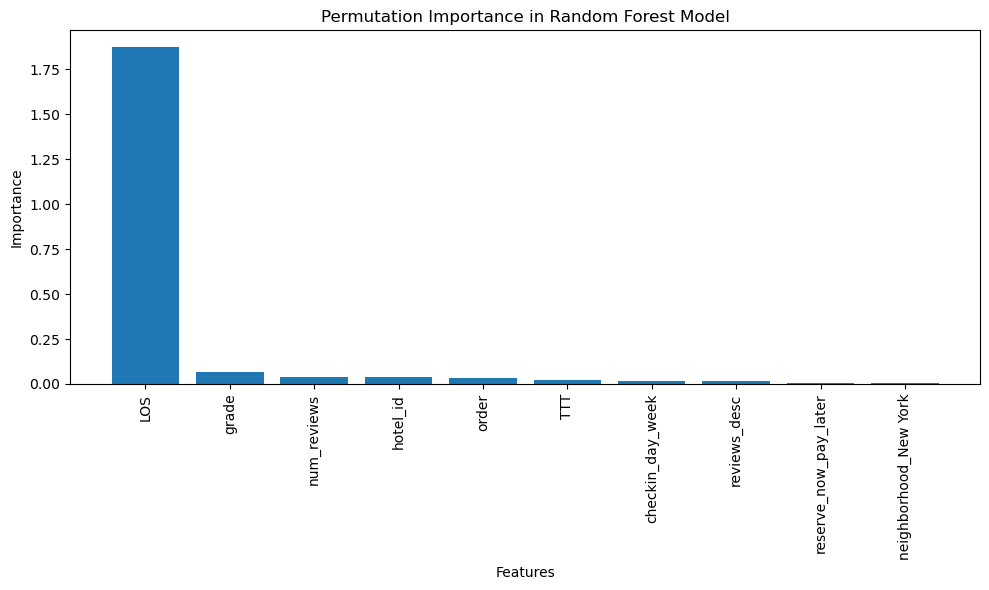

In [16]:
from sklearn.inspection import permutation_importance

# Calculating the importance of features using Permutation Importance
perm_importance = permutation_importance(Random_Forest, X_test, y_test, n_repeats=5)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)[:10]

print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Permutation Importance in Random Forest Model')
plt.tight_layout()
plt.show()

# XGBoost (Extreme Gradient Boosting)

Test MAE:  378.5897
Test MSE:  339601.6863
Test RMSE:  582.7535
Test R2:  0.9580

Train MAE:  365.9868
Train MSE:  317256.3655
Train RMSE:  563.2552
Train R2:  0.9605


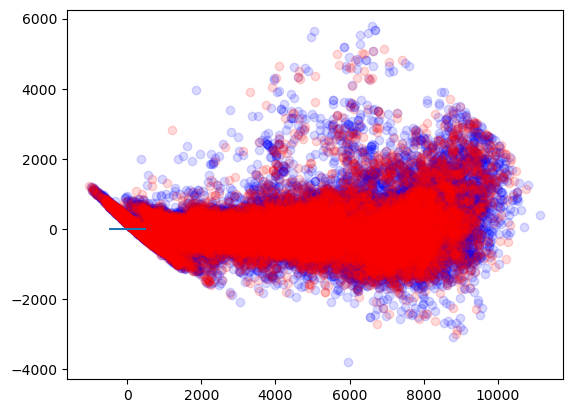

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


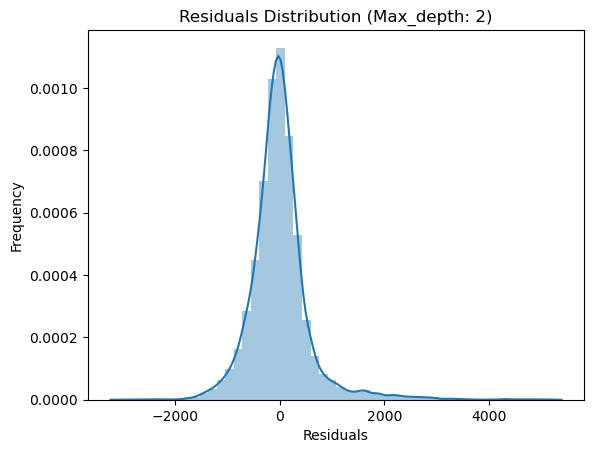

In [17]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=2)

model.fit(X_train, y_train)

# Make predictions
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Evaluate the model
print('Test MAE: ', "%.4f" % mean_absolute_error(y_test, pred_test))
print('Test MSE: ', "%.4f" % mean_squared_error(y_test, pred_test))
print('Test RMSE: ', "%.4f" % np.sqrt(mean_squared_error(y_test, pred_test)))
print('Test R2: ', "%.4f" % r2_score(y_test, pred_test))
print()
print('Train MAE: ', "%.4f" % mean_absolute_error(y_train, pred_train))
print('Train MSE: ', "%.4f" % mean_squared_error(y_train, pred_train))
print('Train RMSE: ', "%.4f" % np.sqrt(mean_squared_error(y_train, pred_train)))
print('Train R2: ', "%.4f" % r2_score(y_train, pred_train))

# Print scatter plot
plt.scatter(pred_train, y_train-pred_train, c='b',alpha=0.15)
plt.scatter(pred_test, y_test-pred_test, c='r',alpha=0.15)
plt.hlines(y=0,xmin=-500,xmax=500)
plt.show()
print()

# Print a histogram the residuals
sns.distplot(y_test-pred_test)
plt.title(f"Residuals Distribution (Max_depth: {2})")
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
print()

## Split the data to training set and test set: TTT < 25 for test

Test MAE:  470.3540
Test MSE:  577372.0825
Test RMSE:  759.8500
Test R2:  0.9292

Train MAE:  286.9427
Train MSE:  195240.1435
Train RMSE:  441.8599
Train R2:  0.9741


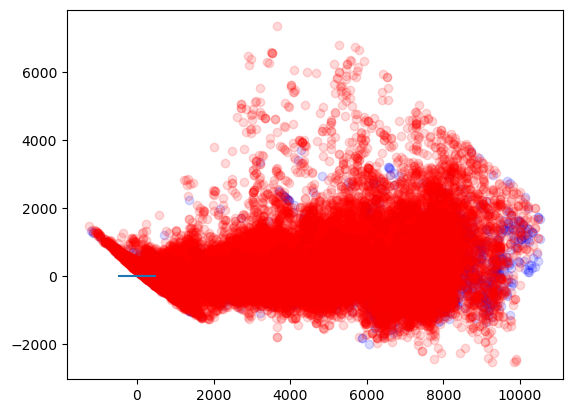

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


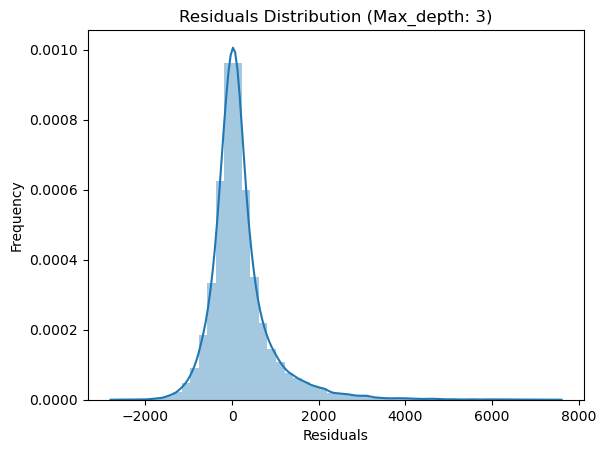

In [18]:
# Dividing the data into groups according to TTT values
X_train = data_min_max_scaled[data_min_max_scaled['TTT'] >= 25].drop('price', axis=1)
y_train = data_min_max_scaled[data_min_max_scaled['TTT'] >= 25]['price']

X_test = data_min_max_scaled[data_min_max_scaled['TTT'] < 25].drop('price', axis=1)
y_test = data_min_max_scaled[data_min_max_scaled['TTT'] < 25]['price']

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=2)

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Evaluate the model
print('Test MAE: ', "%.4f" % mean_absolute_error(y_test, pred_test))
print('Test MSE: ', "%.4f" % mean_squared_error(y_test, pred_test))
print('Test RMSE: ', "%.4f" % np.sqrt(mean_squared_error(y_test, pred_test)))
print('Test R2: ', "%.4f" % r2_score(y_test, pred_test))
print()
print('Train MAE: ', "%.4f" % mean_absolute_error(y_train, pred_train))
print('Train MSE: ', "%.4f" % mean_squared_error(y_train, pred_train))
print('Train RMSE: ', "%.4f" % np.sqrt(mean_squared_error(y_train, pred_train)))
print('Train R2: ', "%.4f" % r2_score(y_train, pred_train))

# Print scatter plot
plt.scatter(pred_train, y_train-pred_train, c='b',alpha=0.15)
plt.scatter(pred_test, y_test-pred_test, c='r',alpha=0.15)
plt.hlines(y=0,xmin=-500,xmax=500)
plt.show()
print()

# Print a histogram the residuals
sns.distplot(y_test-pred_test)
plt.title(f"Residuals Distribution (Max_depth: {3})")
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
print()

## Printing R^2 results

0.9292027820442967
0.9740987930894456


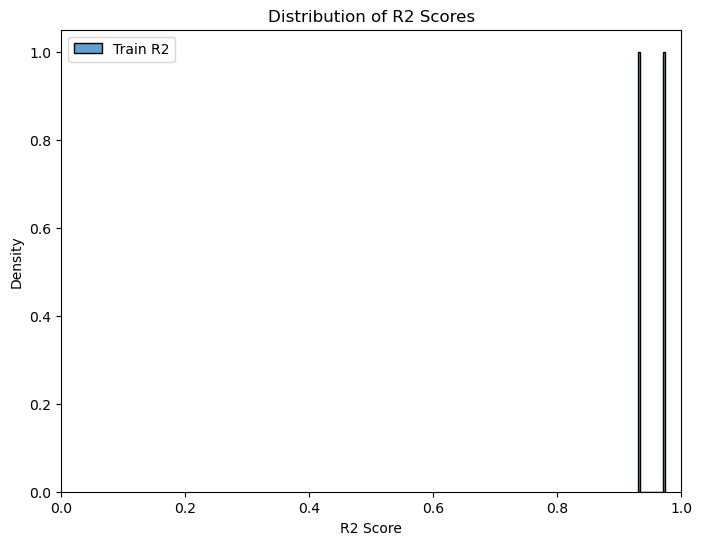

Text(0, 0.5, 'Density')

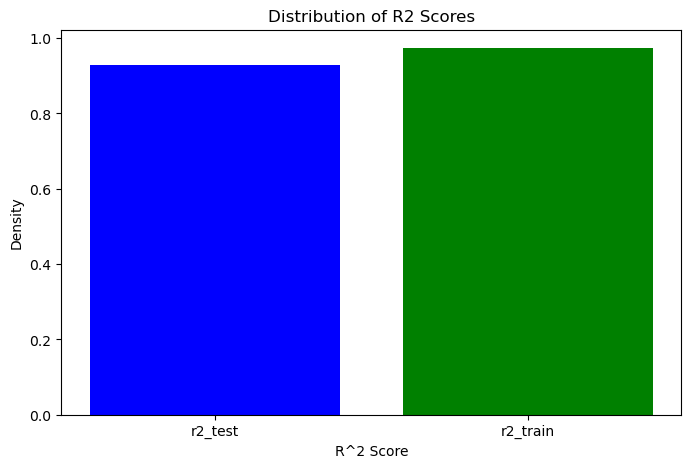

In [19]:
r2_test = r2_score(y_test, pred_test)
r2_train = r2_score(y_train,pred_train)

print(r2_test)
print(r2_train)

# צור גרף של התפלגות ה-R2
plt.figure(figsize=(8, 6))
sns.histplot([r2_train, r2_test], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of R2 Scores')
plt.xlabel('R2 Score')
plt.ylabel('Density')
plt.xlim(0, 1)  # הגבל את גבולות ה-x ל-R2 האפשריים (בין 0 ל-1)
plt.legend(['Train R2', 'Test R2'])
plt.show()

r2_scores = [r2_test, r2_train]
labels = ['r2_test', 'r2_train'] 
# יצירת גרף
plt.figure(figsize=(8, 5))
plt.bar(labels, r2_scores, color=['blue', 'green']) 
plt.title('Distribution of R2 Scores')
plt.xlabel('R^2 Score') 
plt.ylabel('Density')